In [ ]:
!pip install timm albumentations


In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torch.utils.data import DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report
import numpy as np
import cv2
from PIL import Image


In [ ]:
class AlbDataset(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root)
        self.alb_transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = default_loader(path)
        image = self.alb_transform(image=np.array(image))['image']
        return image, label

In [ ]:
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [ ]:
transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile, os, shutil
from sklearn.model_selection import train_test_split
from glob import glob

# 압축 파일 경로 (Google Drive 연동 후)
normal_zip = "/content/drive/MyDrive/DAGM/Class1.zip"
defect_zip = "/content/drive/MyDrive/DAGM/Class1_def.zip"

# 압축 해제
os.makedirs("/content/DAGM_raw/normal", exist_ok=True)
os.makedirs("/content/DAGM_raw/defect", exist_ok=True)

with zipfile.ZipFile(normal_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/DAGM_raw/normal")

with zipfile.ZipFile(defect_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/DAGM_raw/defect")

normal_images = glob("/content/DAGM_raw/normal/**/*.png", recursive=True)
defect_images = glob("/content/DAGM_raw/defect/**/*.png", recursive=True)

# Train/Val Split
train_n, val_n = train_test_split(normal_images, test_size=0.2, random_state=42)
train_d, val_d = train_test_split(defect_images, test_size=0.2, random_state=42)
print("정상 이미지 개수 (train+val):", len(normal_images))
print("불량 이미지 개수 (train+val):", len(defect_images))

# 복사 함수
def copy_to(subset, label, files):
    target_dir = f"/content/{subset}/{label}"
    os.makedirs(target_dir, exist_ok=True)
    for f in files:
        shutil.copy(f, target_dir)

# 데이터 복사
copy_to("train", "normal", train_n)
copy_to("train", "defect", train_d)
copy_to("val", "normal", val_n)
copy_to("val", "defect", val_d)


정상 이미지 개수 (train+val): 1000
불량 이미지 개수 (train+val): 150


In [ ]:

train_dataset = AlbDataset("/content/train", transform_train)
val_dataset = AlbDataset("/content/val", transform_val)


In [ ]:
from collections import Counter
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
weights = [1.0 / class_counts[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = timm.create_model('resnet18', pretrained=True, num_classes=2)
model = model.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
for epoch in range(10):  # epochs
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 19.9999
Epoch 2, Loss: 19.2145
Epoch 3, Loss: 18.5056
Epoch 4, Loss: 16.8009
Epoch 5, Loss: 13.3765
Epoch 6, Loss: 8.3390
Epoch 7, Loss: 4.6274
Epoch 8, Loss: 2.8613
Epoch 9, Loss: 1.7483
Epoch 10, Loss: 1.2058


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=["Defect", "Normal"]))

              precision    recall  f1-score   support

      Defect       1.00      1.00      1.00        30
      Normal       1.00      1.00      1.00       200

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230



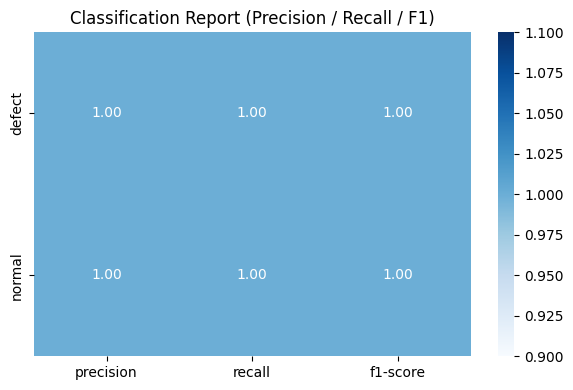

<Figure size 400x400 with 0 Axes>

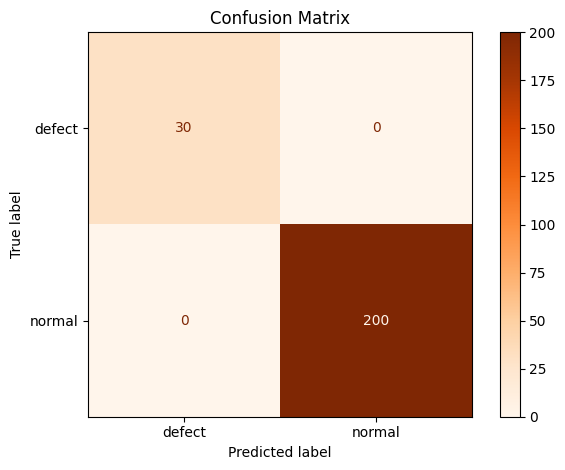

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ✅ 모델을 평가하고 y_true, y_pred 얻는 부분
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ 클래스 이름 (ImageFolder 기준 알파벳 순)
class_names = train_dataset.classes  # 예: ['defect', 'normal']

# ✅ classification_report → dataframe 변환
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# ✅ Confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# ✅ 히트맵 시각화 (Precision / Recall / F1-score)
plt.figure(figsize=(6, 4))
sns.heatmap(df_report.iloc[:len(class_names), :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report (Precision / Recall / F1)")
plt.tight_layout()
plt.show()

# ✅ Confusion Matrix 시각화
plt.figure(figsize=(4, 4))
disp.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
